In [1]:
import importlib

# import ipynb.fs.full.preprocessing0
# import ipynb.fs.full.preprocessing05
# #import ipynb.fs.full.prepossessing075_akistage
# import ipynb.fs.full.preprocessing1
# import ipynb.fs.full.preprocessing2_BT
# import ipynb.fs.full.preprocessing25_BTcorr
# import ipynb.fs.full.preprocessing3_smote
# #import ipynb.fs.full.preprocessing4
# import preprocessing4

# import ipynb.fs.full.runxgboost
# import ipynb.fs.full.postprocessing1_SHAP
# import ipynb.fs.full.postprocessing3_collect

from ipynb.fs.full.slackbot import ping_slack
import pandas as pd
import xgboost as xgb
import numpy as np
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTENC
import matplotlib.pyplot as plt
from PIL import Image
from scipy.interpolate import BSpline, make_interp_spline, interp1d
#import rpy2.robjects as robjects
#from rpy2.robjects.packages import importr
import csv
from dfply import *
from xgboost import XGBClassifier
import itertools
import os
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
from os.path import exists
import logging
import time
import pickle
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn import metrics

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

In [2]:
# Test Site
#sites = ['IUR', 'MCRI', 'MCW', 'UIOWA', 'UMHC', 'UNMC', 'UofU', 'UPITT', 'UTHSCSA', 'UTSW']
sites = ['IUR', 'MCW', 'UIOWA', 'UMHC', 'UNMC', 'UofU', 'UPITT', 'UTHSCSA', 'UTSW', 'KUMC']
site_m='UIOWA'
site_d='UNMC'
year=3000
stg = 'stg01'
oversample = 'raw'
fs = 'nofs'
recol = '005'
model_type = 'catd'
n_jobs=4
suffix = ''
folds = 10

In [3]:
shap_datas = list()
for site_d in sites:
    for site_m in sites:
        for fold in range(folds):
            try:
                shap_data = pd.read_pickle('/home/hoyinchan/blue/Data/data2021/data2021/'+site_m+'/shapdata_cv_'+model_type+'_'+site_m+'_'+site_d+'_'+str(year)+'_'+stg+'_'+fs+'_'+oversample+'_'+str(fold)+'.pkl')
                shap_datas.append(shap_data)
            except:
                pass
shap_datas = pd.concat(shap_datas).reset_index(drop=True)    

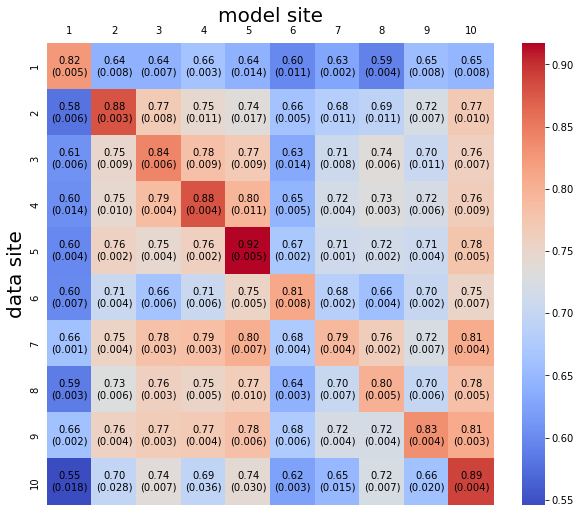

In [4]:
#Heatmap
shap_datas_agg = shap_datas[['site_m', 'site_d', 'roc']].groupby(['site_m', 'site_d']).agg(['mean', 'std']).reset_index()

site_key = {3:'MCW', 4:'UIOWA', 5:'UMHC', 6:'UNMC', 10:'UofU', 8:'UTHSCSA', 2:'KUMC', 9:'UTSW', 7:'UPITT', 1:'IUR'}
site_keyr = {v: k for k, v in site_key.items()}

shap_datas_agg['site_m'] = shap_datas_agg['site_m'].map(site_keyr)
shap_datas_agg['site_d'] = shap_datas_agg['site_d'].map(site_keyr)

shap_datas_agg.columns = ['site_m', 'site_d', 'mean', 'std']

df = shap_datas_agg

# Pivot the DataFrame to create a matrix for the heatmap
pivot_mean = df.pivot("site_m", "site_d", "mean")
pivot_std = df.pivot("site_m", "site_d", "std")

# Plotting
plt.figure(figsize=(10, 8.5))
ax = sns.heatmap(pivot_mean, annot=False, fmt="", cmap='coolwarm')
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, left=False, bottom=False, top = False, labeltop=True)

# Adding mean and standard deviation to the cell text
for i in range(pivot_mean.shape[0]):
    for j in range(pivot_mean.shape[1]):
        mean = pivot_mean.iloc[i, j]
        std = pivot_std.iloc[i, j]
        if pd.notna(mean) and pd.notna(std):
            text = f'{mean:.2f}\n({std:.3f})'
            plt.text(j + 0.5, i + 0.5, text, ha="center", va="center", fontdict={'size': 10})
            
# Rotate x-axis labels and move x-axis to the top
ax.xaxis.set_label_position('top') 
plt.xlabel('model site', fontsize=20)
plt.ylabel('data site', fontsize=20)
plt.savefig('AUROC.svg', format='svg', bbox_inches='tight')

In [145]:
shap_datas2 = shap_datas[['site_m','site_d','roc']]
shap_datas_trans = shap_datas2[shap_datas2['site_m']!=shap_datas2['site_d']]
shap_datas_notrans = shap_datas2[shap_datas2['site_m']==shap_datas2['site_d']]
shap_datas_notrans.columns = ['site_m','site_d','roc_origin']
shap_datas_notrans = shap_datas_notrans[['site_m','roc_origin']]

In [134]:
# shap_datas_trans_mean = shap_datas_trans[['site_m', 'roc']].groupby('site_m').mean().reset_index()
# shap_datas_notrans_mean = shap_datas_notrans[['site_m', 'roc_origin']].groupby('site_m').mean().reset_index()

# shap_datas_trans_std = shap_datas_trans[['site_m', 'roc']].groupby('site_m').mean().reset_index()
# shap_datas_notrans_std = shap_datas_notrans[['site_m', 'roc_origin']].groupby('site_m').mean().reset_index()
# shap_datas_trans_std.columns = ['site_m', 'roc_std']
# shap_datas_notrans_std.columns = ['site_m', 'roc_origin_std']

In [146]:
shap_datas_trans_x = shap_datas_trans.merge(shap_datas_notrans, on = 'site_m', how='left')

In [148]:
shap_datas_trans_x['transport'] = shap_datas_trans_x['roc']/shap_datas_trans_x['roc_origin']

In [154]:
shap_datas_trans_stat = shap_datas_trans_x[['site_m', 'transport']].groupby('site_m').agg(['mean', 'std']).reset_index()

In [156]:
shap_datas_trans_stat.columns = ['site_m', 'transport_mean', 'transport_std']

In [159]:
shap_datas_trans_stat

,site_m,transport_mean,transport_std
0,IUR,0.769097,0.029345
1,KUMC,0.804165,0.066211
2,MCW,0.851466,0.069226
3,UIOWA,0.822559,0.068179
4,UMHC,0.781093,0.056786
5,UNMC,0.853353,0.056841
6,UPITT,0.947995,0.063927
7,UTHSCSA,0.889859,0.076188
8,UTSW,0.888329,0.056222
9,UofU,0.757700,0.070323


In [ ]:
#Spider Plot
def create_radar_chart_with_confidence(df):
    # Categories (site_d)
    categories = df['site_d'].unique()
    N = len(categories)

    # Angle for each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Initialize the radar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], categories)

    # Draw each site_m with its confidence interval
    for site_m in df['site_m'].unique():
        site_df = df[df['site_m'] == site_m]
        values = site_df['mean'].tolist()
        values += values[:1]

        # Confidence interval calculation
        ci_upper = (site_df['mean'] + 1.96 * site_df['std']).tolist()
        ci_upper += ci_upper[:1]

        ci_lower = (site_df['mean'] - 1.96 * site_df['std']).tolist()
        ci_lower += ci_lower[:1]

        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Model {site_m}')
        ax.fill_between(angles, ci_lower, ci_upper, alpha=0.4)

    # Add legend
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    plt.savefig('AUROC_spider.svg', format='svg', bbox_inches='tight')

create_radar_chart_with_confidence(shap_datas_agg)

In [ ]:
#Feature rank map
models = dict()
for site_m in sites:
    for fold in range(10):
        models[(site_m, fold)] = pickle.load(open('/home/hoyinchan/blue/Data/data2021/data2021/'+site_m+'/boosttrap_'+model_type+'_'+site_m+'_'+str(year)+'_'+stg+'_'+fs+'_'+oversample+'_'+str(fold)+'.pkl', 'rb'))

df_importances = list()
for site_m in sites:
    for fold in range(10):
        importances = models[(site_m, fold)][-3].get_feature_importance(prettified=True)
        importances['site'] = site_m
        importances['fold'] = fold
        importances['rank'] = importances['Importances'].rank(method='min', ascending=False)-1      
        importances = importances[importances['rank']<100]
        importances['rank'] = (100-importances['rank'])/100
        df_importances.append(importances)

df_importances = pd.concat(df_importances)
df_importances = df_importances[['Feature Id', 'rank', 'site']].groupby(['Feature Id', 'site']).median().reset_index()
df_importances['Feature Id no unit'] = df_importances['Feature Id'].str.split('(').str[0]

df_importances_raw2 = df_importances.copy()

df_importances_stat = df_importances[['Feature Id no unit', 'rank']].groupby(['Feature Id no unit']).quantile([0.25, 0.5, 0.75]).reset_index().pivot(index='level_1', columns=['Feature Id no unit'], values='rank').T.reset_index()
df_importances_stat['IQR'] = df_importances_stat[0.75]-df_importances_stat[0.25]
df_importances_stat.index = df_importances_stat['Feature Id no unit'].copy()
df_importances_stat = df_importances_stat[[0.5, 'IQR']]
df_importances_stat.columns = ['Median', 'IQR']

df_importances_count = df_importances[['Feature Id no unit', 'site']].groupby('Feature Id no unit').count()/10
df_importances_count.columns = ['Count']

df_importances_stat = df_importances_stat.merge(df_importances_count, left_index=True, right_index=True)

df_importances_top5 = df_importances_stat[['Median', 'Count']].sort_values('Median',ascending=False).groupby('Count').rank(method='first', ascending=False)
df_importances_top5.columns = ['Label_rank']

df_importances_top5=df_importances_top5[df_importances_top5['Label_rank']<=5]
df_importances_top5['Label_rank'] = -1*(df_importances_top5['Label_rank']-3)-2
df_importances_stat = df_importances_stat.merge(df_importances_top5[['Label_rank']], left_index=True, right_index=True, how='left').fillna(-100)

In [ ]:
# df_importances[df_importances['Feature Id'].str.contains('1863-0')]
# df_importances[df_importances['Feature Id'].str.contains('39.95')]
# df_importances[df_importances['Feature Id'].str.contains('1963-8')]

In [ ]:
df_importances[df_importances['Feature Id no unit']=='LAB::1962-0']

In [ ]:
df_importances[df_importances['Feature Id no unit']=='LAB::LG4454-7']

In [ ]:
df_importances[df_importances['Feature Id no unit']=='LAB::LG2807-8']

In [ ]:
df_importances['Feature Id no unit'].unique()

In [ ]:
#Translate label to omop

def translate_omop_pre():
#        path_concept = "/home/hoyinchan/code/concept_vocab/"
    path_concept ="/blue/yonghui.wu/hoyinchan/concept_vocab/"
    concept = pd.read_csv(path_concept+'CONCEPT.csv', sep='\t')
    concept['vocabulary_id'] = concept['vocabulary_id'].replace('CPT4', 'HCPCS')
    concept['concept_code'] = concept['concept_code'].astype(str)
    return concept
#        concept_cpt4 = pd.read_csv(path_concept+'CONCEPT_CPT4.csv', sep='\t')
#        concept = pd.concat([concept, concept_cpt4])

def translate_omop(label):
    def get_vocabulary_id(prefix):
        return {
            'LAB': 'LOINC',
            'MEDRX': 'RxNorm',
            'PXCH': 'HCPCS',
            'PX09': 'ICD9Proc',
            'PX10': 'ICD10PCS',
            'MEDATC':'ATC'
            
        }.get(prefix, None)

    try:
        prefix, code, extra = label.split(':')
        try:
            extra = extra.split('(')[0]    
        except:
            pass
    #    extra = extra.replace('.','')
        if prefix == 'PX':
            prefix = prefix+code
        if prefix == 'MED':
            prefix = prefix+code  
        if prefix == 'DX':
            prefix = prefix+code              
        label_omop = concept[(concept['concept_code'] == extra) & (concept['vocabulary_id'] == get_vocabulary_id(prefix))]['concept_name'].iloc[0]
    except:
        label_omop = label
    return label_omop

#concept = translate_omop_pre()
#omop_label = {x:translate_omop(x, concept) for x in df_importances_stat[df_importances_stat['Label_rank']!=-100].index}
# first_dixt = {x:plotshapsn.translate_omop(x) for x in plotshapsn.shapdf['Feature'].unique()}
# Then ask ChatGPT to extract "extract the medical procedure, medication or Lab measurement from..."
def extra_translate_omop(label):
    extracted_data = {
        'AGE': 'AGE',
        'DX:09:428bt6': 'Heart failure (428)',
        'LAB::10466-1': 'Anion gap 3 (10466-1)',
        'LAB::14979-9': 'aPTT (14979-9)',
        'LAB::17861-6': 'Calcium (17861-6)',
        'LAB::1863-0': 'Anion gap 4 (1863-0)',
        'LAB::19123-9': 'Magnesium (19123-9)',
        'LAB::1920-8': 'Aspartate aminotransferase (1920-8)',
        'LAB::1962-0': 'Deprecated Bicarbonate (1962-0)',
        'LAB::1963-8': 'Bicarbonate (1963-8)',
        'LAB::2028-9': 'Carbon dioxide, total (2028-9)',
        'LAB::20570-8': 'Hematocrit (20570-8)',
        'LAB::2075-0': 'Chloride (2075-0)',
        'LAB::2160-0': 'Creatinine (2160-0)',
        'LAB::2340-8': 'Glucose (2340-8)',
        'LAB::2345-7': 'Glucose (2345-7)',
        'LAB::26464-8': 'Leukocytes (26464-8)',
        'LAB::26478-8': 'Lymphocytes/100 leukocytes (26478-8)',
        'LAB::2708-6': 'Oxygen saturation (2708-6)',
        'LAB::3094-0': 'Urea nitrogen (3094-0)',
        'LAB::3097-3': 'Urea nitrogen/Creatinine ratio (3097-3)',
        'LAB::33037-3': 'Anion gap (33037-3)',
        'LAB::38483-4': 'Creatinine (38483-4)',
        'LAB::4092-3': 'Vancomycin (4092-3)',
        'LAB::41653-7': 'Glucose (41653-7)',
        'LAB::43413-4': 'Blood product units requested (43413-4)',
        'LAB::4544-3': 'Hematocrit (4544-3)',
        'LAB::48642-3': 'GFR predicted among non-blacks (48642-3)',
        'LAB::5902-2': 'Prothrombin time (PT) (5902-2)',
        'LAB::6690-2': 'Leukocytes (6690-2)',
        'LAB::713-8': 'Eosinophils/100 leukocytes (713-8)',
        'LAB::731-0': 'Lymphocytes (731-0)',
        'LAB::736-9': 'Lymphocytes/100 leukocytes (736-9)',
        'LAB::777-3': 'Platelets (777-3)',
        'LAB::788-0': 'Erythrocyte distribution width (788-0)',
        'LAB::789-8': 'Erythrocytes (789-8)',
        'LAB::LG5665-7': 'Alkaline phosphatase (LG5665-7)',
        'MED:ATC:C03CA': 'Sulfonamides, plain (C03CA)',
        'MED:ATC:J01CG': 'Beta-lactamase inhibitors (J01CG)',
        'ORIGINAL_BMI': 'BMI',
        'PX:09:39.61': 'Extracorporeal circulation auxiliary to open heart surgery (39.61)',
        'PX:09:39.95': 'Hemodialysis (39.95)',
        'PX:09:96.72': 'Continuous invasive mechanical ventilation >96 hrs (96.72)',
        'PX:09:99.04': 'Transfusion of packed cells (99.04)',
        'PX:10:5A1955Z': 'Respiratory Ventilation >96 hrs (5A1955Z)',
        'PX:CH:36415': 'Venous blood collection (36415)',
        'PX:CH:97116': 'Therapeutic procedure; gait training (97116)',
        'PX:CH:A6257': 'Transparent film dressing (A6257)',
        'PX:CH:J1940': 'Furosemide injection (J1940)',
        'PX:CH:J2543': 'Piperacillin/tazobactam injection (J2543)',
        'LAB::2777-1': 'Phosphate (789-8)',
        'LAB::1975-2': 'Bilirubin.total (1975-2)',
        'LAB::2823-3': 'Potassium (2823-2)',
        'LAB::2951-2': 'Sodium (2951-2)',
        'LAB::718-7': 'Hemoglobin (718-7)'
    }
    return extracted_data.get(label, label)

In [ ]:
#Customize height if overlap
df_importances_stat['cusheight'] = 1
df_importances_stat.loc['PX:09:96.72', 'cusheight'] = 1.75
df_importances_stat.loc['LAB::3097-3', 'cusheight'] = 1.75
df_importances_stat.loc['LAB::1863-0', 'cusheight'] = 1.75
df_importances_stat.loc['PX:09:39.95', 'cusheight'] = 1.75
df_importances_stat.loc['LAB::41653-7', 'cusheight'] = 1.75
df_importances_stat.loc['LAB::41653-7', 'cusheight'] = 1.75

In [ ]:
#len(df_importances_raw2['Feature Id'].unique()) #667
#len(df_importances_stat.index) #568

In [ ]:
#Plot
df = df_importances_stat

# Scatter plot
plt.figure(figsize=(20, 12))
scatter = plt.scatter(df['Median'], df['Count'], c=df['IQR'], cmap='coolwarm', s=200)

# Colorbar for IQR
cbar  = plt.colorbar(scatter, label='IQR Value')
cbar.ax.tick_params(labelsize=12)  # Increase font size for color bar ticks
cbar.set_label('IQR Value', fontsize=20)  # Increase font size for color bar label

# Add text for points where Label is True with annotation lines
for idx, row in df.iterrows():
    if row['Label_rank']!=-100:
        plt.annotate(
            extra_translate_omop(idx), 
            xy=(row['Median'], row['Count']), 
            xytext=(row['Median'] + 0.07*row['Label_rank']-0.06, row['Count'] + 0.03*[-row['cusheight'] if row['Label_rank']%2==1 else row['cusheight']][0]),  # adjust text position
            arrowprops=dict(arrowstyle='-', lw=1),
            fontsize=9
        )

# Set y-ticks to be at intervals of 0.1
plt.yticks(np.arange(0, 1.1, 0.1))

# Adding grid lines
plt.grid(True)
        
# Increase font size for x and y ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)    
    
plt.xlabel('Importance ranking (median of soft ranking)', fontsize = 20)
plt.ylabel('Commonality across sites', fontsize= 20)
plt.savefig('feature_ranks.svg', bbox_inches='tight')

In [ ]:
df_importances_stat

In [ ]:
r2 = pd.read_csv('MetaRegression/r2svg.csv')
#r2['Feature Id no unit'] = r2['0'].str.split('(').str[0]
#r2.index = r2['Feature Id no unit']
#df_importances_stat2 = df_importances_stat.merge(r2, how='inner', right_index=True, left_index=True)

In [ ]:
shap_datas_agg = shap_datas[['site_m', 'site_d', 'roc']].groupby(['site_m', 'site_d']).agg(['mean', 'std']).reset_index()
shap_datas_agg.columns = ['site_m', 'site_d', 'mean', 'std']
shap_datas_agg = shap_datas_agg[['site_m', 'site_d', 'mean']]

shap_datas_agg_1  = shap_datas_agg[shap_datas_agg['site_m']==shap_datas_agg['site_d']]
shap_datas_agg_2  = shap_datas_agg[shap_datas_agg['site_m']!=shap_datas_agg['site_d']]
shap_datas_agg_2 = shap_datas_agg_2[['site_m', 'mean']].groupby('site_m').mean().reset_index()
shap_datas_agg_2.columns = ['site_m', 'ext_mean']

shap_datas_agg_1 = shap_datas_agg_1.merge(shap_datas_agg_2, on='site_m', how='inner')
shap_datas_agg_1['transportability'] = shap_datas_agg_1['ext_mean']/shap_datas_agg_1['mean']
#shap_datas_agg_1.sort_values('transportability',ascending=False)

In [ ]:
df_importances_raw = df_importances_raw2.copy()
df_importances_raw = df_importances_raw.merge(r2[['0', 'r.sq_spline_noAUC']], left_on='Feature Id',right_on='0', how='inner')

In [ ]:
# Create a DataFrame of all possible combinations
all_combos = pd.MultiIndex.from_product([
    df_importances_raw['Feature Id no unit'].unique(),
    df_importances_raw['site'].unique()
], names=['Feature Id no unit', 'site']).to_frame(index=False)

# Merge with the original DataFrame
df_full = pd.merge(all_combos, df_importances_raw, on=['Feature Id no unit', 'site'], how='left')

In [ ]:
# Fill missing values with 0
df_full['r.sq_spline_noAUC'] = df_full['r.sq_spline_noAUC'].fillna(0)
df_full['rank'] = df_full['rank'].fillna(0)

In [ ]:
df_importances_raw = df_full

df_importances_raw = df_importances_raw.merge(shap_datas_agg_1[['site_m','transportability']], left_on='site',right_on='site_m',how='left')
#df_importances_raw['Feature Id no unit'] = df_importances_raw['Feature Id'].str.split('(').str[0]
df_importances_raw = df_importances_raw[['Feature Id no unit', 'rank', 'site', 'r.sq_spline_noAUC', 'transportability']]
df_importances_raw['Feature Id no unit'] = df_importances_raw['Feature Id no unit'].apply(extra_translate_omop)

In [ ]:
# Sort DataFrame by 'transportability' in descending order
df_importances_raw = df_importances_raw.sort_values(by='transportability', ascending=False)

# Create a mapping for 'site' to display transportability
df_importances_raw['site_label'] = df_importances_raw['site'] + " (" + df_importances_raw['transportability'].round(2).astype(str) + ")"

# Normalize 'r.sq_spline_noAUC' for size scaling
size = df_importances_raw['r.sq_spline_noAUC'] * 100  # Adjust the scaling factor as needed

# Assign unique colors to each unique 'Feature Id no unit'
colors = plt.cm.viridis(np.linspace(0, 1, len(df_importances_raw['Feature Id no unit'].unique())))
color_dict = dict(zip(df_importances_raw['Feature Id no unit'].unique(), colors))

# Create the scatter plot
plt.figure(figsize=(12, 8))
for feature in df_importances_raw['Feature Id no unit'].unique():
    idx = df_importances_raw['Feature Id no unit'] == feature
    plt.scatter(df_importances_raw['site_label'][idx], df_importances_raw['rank'][idx], 
                s=size[idx], c=[color_dict[feature]], label=feature, alpha=0.7)

# Add labels and title
plt.xlabel('Site (Transportability)')
plt.ylabel('Rank')
plt.title('Scatter Plot by Feature, Site, and Rank')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add a legend
plt.legend(title='Feature Id no unit', bbox_to_anchor=(1.05, 1), loc='upper left')

# Turn on grid lines
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
df_importances_avg = df_importances_raw[['site','rank','r.sq_spline_noAUC']].groupby('site').sum()

# Calculate the weighted rank for each row
df_importances_raw['weighted_rank'] = df_importances_raw['rank'] * df_importances_raw['r.sq_spline_noAUC']

# Group by 'site' and calculate the sum of weighted ranks and the sum of weights
grouped = df_importances_raw.groupby('site').agg(
    total_weighted_rank=pd.NamedAgg(column='weighted_rank', aggfunc='sum'),
    total_weight=pd.NamedAgg(column='r.sq_spline_noAUC', aggfunc='sum')
)

# Calculate the weighted average of rank for each site
grouped['weighted_avg_rank'] = grouped['total_weighted_rank'] / grouped['total_weight']

# Reset index of the grouped DataFrame to merge
grouped_reset = grouped.reset_index()

# Merge the weighted average rank back to the original DataFrame
df_importances_raw = pd.merge(df_importances_raw, grouped_reset[['site', 'weighted_avg_rank']], on='site', how='left')

In [ ]:
# Filter out the data for the site 'IUR'
#df_filtered = df_importances_raw[df_importances_raw['site'] != 'IUR']
df_filtered = df_importances_raw.copy()
df_filtered['site'] = df_filtered['site'].map(site_keyr)

# Selecting the data for the plot
x = df_filtered['weighted_avg_rank']
y = df_filtered['transportability']

# Perform linear regression
slope, intercept, r_value, _, _ = stats.linregress(x, y)
fit_line = slope * x + intercept
r_squared = r_value**2  # Coefficient of determination (R^2)

# Creating the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y)

# Labeling each point with its site
label_offset_y = 0.0025
for i, row in df_filtered.iterrows():
    plt.text(row['weighted_avg_rank'], row['transportability'] + label_offset_y, row['site'], fontsize=9, ha='center')

# Plotting the linear fit line
plt.plot(x, fit_line, color='red', label=f'Linear fit: y={slope:.2f}x+{intercept:.2f}')

# Adding labels, title, legend, grid, and R^2 value
plt.xlabel('Weighted Average Rank')
plt.ylabel('Transportability')
plt.legend()
plt.grid(True)
plt.text(0.05, 0.95, f'$R^2$ = {r_squared:.2f}', transform=plt.gca().transAxes)  # Display R^2 on plot

# Show the plot
plt.show()

In [ ]:
#ROC plot

shap_datas = shap_datas.dropna()

from itertools import chain
out1 = (shap_datas.groupby(['site_m', 'site_d'], as_index=False)['y_test']
         .agg(lambda x: list(chain.from_iterable(x)))
       )
out2 = (shap_datas.groupby(['site_m', 'site_d'], as_index=False)['pred']
         .agg(lambda x: list(chain.from_iterable(x)))
       )

roc_plot = out1.merge(out2, on=['site_m', 'site_d'],  how='left')

pivot_df = roc_plot

pivot_df['site_m'] = pivot_df['site_m'].map(site_keyr)
pivot_df['site_d'] = pivot_df['site_d'].map(site_keyr)
pivot_df = pivot_df.merge(shap_datas_agg, on=['site_m','site_d'],how='left')

plt.figure(figsize=(10, 8.5))
for index, row in pivot_df.iterrows():
    y_test = row['y_test']
    pred = row['pred']
    # Compute ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)

    # Plotting
    lw = 2
    plt.plot(fpr, tpr)
#             lw=lw, label=str(row['site_m'])+':'+str(row['site_d']) % mean)
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC', fontsize=20)
#plt.legend(loc="lower right")
plt.savefig('ROC.svg', format='svg', bbox_inches='tight')
#plt.show()